In [2]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle

### 函数定义

In [3]:
def work_sext(
    image_path: str,
    config_path: str,
    out_path: str,
    flag_path: str,
    weight_path: str,
    out_para_path: str,
    filter_path: str,
):
    """
    Do astrometry by source-extractor.

    Do astrometry by source-extractor, the basic use of source-extractor is 'source-extractor  -c ' + fp_config + fp_image'

    Parameters
    ----------
    image_path : str
        The image fits to be processed, *.fits.
    config_path : str
        The config file of source-extractor, *.sex.
    out_path : str
        The name of the output catalog.
    out_para_path : str
        The parameters of the output catalog, *.param.
    filter_path : str
        The filter of the image, *.conv.

    Returns
    -------
    None

    Examples
    -------
    >>> work_sext(fp_img,fp_config_sext,fp_out_sext,fp_para_sext,fp_filter_sext)
    """
    fp_image = image_path
    fp_config = config_path
    fp_out = out_path
    fp_flg = flag_path
    fp_wht = weight_path
    fp_para = out_para_path
    fp_filter = filter_path

    cmd_sex = (
        "sex -c "
        + fp_config + " "
        + fp_image
        + " -CATALOG_NAME "
        + fp_out
        + " -FLAG_IMAGE "
        + fp_flg
        + " -WEIGHT_IMAGE "
        + fp_wht
        + " -PARAMETERS_NAME "
        + fp_para
        + " -FILTER_NAME "
        + fp_filter
    )

    os.system(cmd_sex)

def gaiadr3_query(
    ra: list,
    dec: list,
    rad: float = 1.0,
    maxmag: float = 25,
    maxsources: float = 1000000,
):
    """
    Acquire the Gaia DR3.

    This function uses astroquery.vizier to query Gaia DR3 catalog.

    Parameters
    ----------
    ra : list
        RA of center in degrees.
    dec : list
        Dec of center in degrees.
    rad : float
        Field radius in degrees.
    maxmag : float
        Upper limit magnitude.
    maxsources : float
        Maximum number of sources.

    Returns
    -------
    Table
        table of reference catalog.

    Examples
    --------
    >>> catalog = gaiadr3_query(ra, dec, rad, maxmag, maxsources)
    """

    vquery = Vizier(
        columns=["RA_ICRS", "DE_ICRS", "pmRA", "pmDE", "Plx", "RVDR2", "Gmag"],
        row_limit=maxsources,
        column_filters={"Gmag": ("<%f" % maxmag), "Plx": ">0"},
    )
    coord = SkyCoord(ra=ra, dec=dec, unit=u.deg, frame="icrs")
    r = vquery.query_region(coord, radius=rad * u.deg, catalog="I/355/gaiadr3")

    return r[0]

def ideal_cel_coord(xi, eta, ra_c, dec_c):
    ra_c = np.deg2rad(ra_c)
    dec_c = np.deg2rad(dec_c)

    ra = np.arctan(xi / (np.cos(dec_c) - eta * np.sin(dec_c))) + ra_c
    dec = np.arctan(
        (eta * np.cos(dec_c) + np.sin(dec_c))
        / (np.cos(dec_c) - eta * np.sin(dec_c))
        * np.cos(ra - ra_c)
    )
    ra = np.degrees(ra)
    dec = np.degrees(dec)

    return ra, dec

def cel_ideal_coord(ra, dec, ra_c, dec_c):

    ra = np.radians(ra)
    dec = np.radians(dec)
    ra_c = np.radians(ra_c)
    dec_c = np.radians(dec_c)

    xi = (np.cos(dec) * np.sin(ra - ra_c)) / (
        np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    )
    eta = (
        np.cos(dec_c) * np.sin(dec) - np.sin(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    ) / (np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c))

    return xi, eta

def pos_side(ra_a, dec_a, ra_b, dec_b):
    ra_a_c = np.deg2rad(ra_a)
    dec_a_c = np.deg2rad(dec_a)
    ra_b_c = np.deg2rad(ra_b)
    dec_b_c = np.deg2rad(dec_b)

    a_vector = np.array([np.cos(dec_a_c) * np.cos(ra_a_c), np.cos(dec_a_c) * np.sin(ra_a_c), np.sin(dec_a_c)])
    b_vector = np.array([np.cos(dec_b_c) * np.cos(ra_b_c), np.cos(dec_b_c) * np.sin(ra_b_c), np.sin(dec_b_c)])
    return np.rad2deg(np.arccos(np.sum(a_vector * b_vector, axis=0)))

def cal_plate_model(X_x, X_y, Y_xi, Y_eta, cof):
    
    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T
    
    A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi
    A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

    A_CD = np.array([A_CD1, A_CD2])

    return A_CD

def use_plate_model(X_x, X_y, A_CD, cof):

    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T

    xi_eta = A_CD @ X_xy.T * (np.pi / 180)

    return xi_eta

# def cal_plate_model(X_x, X_y, Y_xi, Y_eta):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
    
#     A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi

#     A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

#     A_CD = np.array([A_CD1, A_CD2])

#     return A_CD

# def use_plate_model(X_x, X_y, A_CD):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     xi_eta = A_CD @ X_xy.T * (np.pi / 180)

#     return xi_eta

def write_ds9_region(filename, data, str_x, str_y):

    with open(filename, "w") as f:
        f.write(
            'global color=red dashlist=8 3 width=1 font="helvetica 10 normal roman" '
            "select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1"
            + "\n"
        )
        f.write("physical" + "\n")
        for i in range(len(data)):
            f.write(
                "circle("
                + str("%12.6f" % (data[str_x][i]))
                + ",  "
                + str("%12.6f" % (9232 - data[str_y][i]))
                + ","
                + str(15)
                + ")"
                + "\n"
            )

### 文件路径

In [4]:
CONFIG_PATH = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/"

band = "C1"

img_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.fits'
flg_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_flg.fits'
wht_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_wht.fits'

sext_config_path: str = CONFIG_PATH + "astrom.sex"
sext_para_path: str = CONFIG_PATH + "astrom.param"
sext_filter_path: str = CONFIG_PATH + "gauss_4.0_7x7.conv"
sext_out_path: str = os.path.basename(img_path).replace(".fits", ".acat")

In [5]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

In [6]:
pointing_ra, pointing_dec
CD1_1, CD1_2, CD2_1, CD2_2

(-1.3888888888888e-05, -0.0, -0.0, 1.38888888888888e-05)

### source-extractor结果筛选

In [7]:
fp_img = img_path
fp_flg = flg_path
fp_wht = wht_path
fp_config_sext = sext_config_path
fp_out_sext = sext_out_path
fp_para_sext = sext_para_path
fp_filter_sext = sext_filter_path

work_sext(fp_img,fp_config_sext,fp_out_sext, fp_flg, fp_wht, fp_para_sext,fp_filter_sext)
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out = Table(hdu_list[2].data)

> 
----- SExtractor 2.25.0 started on 2024-01-30 at 10:06:27 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.fits
----- Measuring from: CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.fits [1/1]
      "Unnamed" / no ext. header / 9216x9232 / 32 bits (floats)
> Looking for CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_flg.fits
----- Flagging  from: CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_flg.fits [1/1]
      "Unnamed" / no ext. header / 9216x9232 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting

Filename: CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.acat
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [13440A]   
  2  LDAC_OBJECTS    1 BinTableHDU    166   6925R x 40C   [1E, 1E, 1D, 1D, 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1E, 1I, 1J]   


> Line: 9232  Objects:     6948 detected /     6800 sextracted
      Objects: detected 6948     / sextracted 6925            

> Closing files
> 
> All done (in 24.5 s: 377.4 lines/s , 283.1 detections/s)


In [8]:
log_path = "/home/fangwf/MCI_SimData/240119/L0/log_Data"
filename = "star_info_SN_1.fits"

hdu_info = fits.open(os.path.join(log_path, filename))
l0_info = Table(hdu_info[1].data)
filter_x = l0_info[f"posX_{band}"]
filter_y = 9232 - l0_info[f"posY_{band}"]
filter_mag = l0_info["st_magbp"]


In [9]:
sext_out["filter"] = 0
sext_out[f"mag_{band}"] = np.zeros_like(sext_out["filter"], dtype=float)

for l0_x, l0_y, l0_mag in zip(filter_x, filter_y, filter_mag):
    index = (sext_out["X_IMAGE"] - l0_x) ** 2 + (sext_out["Y_IMAGE"] - l0_y) ** 2 < 4
    if np.sum(index) == 1:
        sext_out["filter"][index] = 1
        sext_out[f"mag_{band}"][index] = l0_mag

sext_out_filter = sext_out[sext_out["filter"] == 1]

In [10]:
sext_out_filter

X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,XMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,YMIN_IMAGE,ALPHA_J2000,DELTA_J2000,ALPHAWIN_J2000,DELTAWIN_J2000,X_WORLD,Y_WORLD,X2WIN_IMAGE,Y2WIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,THETAWIN_IMAGE,ERRTHETAWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,ELLIPTICITY,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,FLUX_AUTO,FLUXERR_AUTO,BACKGROUND,MAG_AUTO,MAGERR_AUTO,ISOAREAF_IMAGE,FWHM_IMAGE,FLAGS,IMAFLAGS_ISO,filter,mag_C1
float32,float32,float64,float64,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,int32,int64,float64
1192.1239,262.13882,1202.805816274043,219.67162870173198,1182,1247,337,1,265.2555822218223,-54.15845171182302,265.25533000261873,-54.15904170247579,265.2555822218223,-54.15845171182302,155.36321073532727,3667.0682186180234,0.44067931054014076,2.827044659732064,61.4561,6.7512436,1.7104383,0.5849146,-80.12319,-78.73688,0.021302052,0.0009025071,0.93799126,0.0008534789,9.446421e-05,2.3753926e-05,8.130021e-06,3050.5945,45.8761,0.015543058,-8.710961,0.016331716,2870,197.32831,18,16,1,20.766329
8026.265,152.37714,8026.010750127309,152.54623156179645,7992,8061,186,116,265.09347647040494,-54.15997612236688,265.09348250675606,-54.15997377794243,265.09347647040494,-54.15997612236688,1.7172780121770967,1.068824795360749,0.0009715177742802655,0.0006138814928419776,1.3190415,1.0228549,0.031276267,0.024641313,10.397397,7.715498,0.5871668,0.9433993,0.07776868,1.8320696e-05,1.4205399e-05,4.3440423e-07,3.4222452e-07,5913.3027,65.841835,0.018361581,-9.429575,0.012092098,3657,5.7680726,0,16,1,16.616312
863.0639,89.17614,863.0645167557685,89.32269187266297,843,883,107,72,265.26339251789295,-54.160848474961206,265.2633924990744,-54.16084643952592,265.26339251789295,-54.160848474961206,0.6568151647299405,0.6940417487369247,0.0014830725416517868,0.0016686974740203603,0.842093,0.80108446,0.040900327,0.038456902,61.767673,81.598564,1.5251371,1.4433327,0.11199206,1.16958745e-05,1.11259915e-05,5.680648e-07,5.3411685e-07,1322.903,29.252798,0.015666356,-7.80382,0.024014262,912,1.8030344,2,16,1,17.673443
1421.1842,73.52232,1421.0633432031996,73.64088991381868,1402,1440,91,57,265.2501538029194,-54.16107490419911,265.25015666571545,-54.1610732556798,265.2501538029194,-54.16107490419911,0.6832758486912855,0.708162894930595,0.0016754028892111007,0.001805363792040036,0.8541846,0.8135154,0.042626847,0.04078871,55.76338,73.975464,1.466554,1.4150147,0.06413317,1.1863755e-05,1.1298709e-05,5.9204456e-07,5.66503e-07,1242.1683,28.727879,0.016272122,-7.735451,0.025116142,967,1.4894941,0,16,1,18.122917
2660.3435,50.466118,2660.2294475652557,50.624304130744335,2646,2677,64,37,265.22076001286507,-54.16140995495505,265.22076271340745,-54.161407756918685,265.22076001286507,-54.16140995495505,0.6614485855978938,0.6986702392269706,0.0029251887065980644,0.0031975777701424637,0.84877455,0.79981285,0.056774855,0.053845912,58.73015,73.607185,1.5160404,1.4352734,0.05801654,1.17886075e-05,1.1108409e-05,7.8854447e-07,7.478531e-07,683.7112,21.251919,0.015487025,-7.0871816,0.033756334,638,0.9554331,0,16,1,20.075052
217.62123,33.59869,217.61639973992396,33.72205353068271,206,230,44,23,265.278704924876,-54.16160814501636,265.27870503502464,-54.16160643156495,265.278704924876,-54.16160814501636,0.6627212716953865,0.6459969789221746,0.006699761614228907,0.006302436709539789,0.8336008,0.78347176,0.082798764,0.078400016,39.046783,27.960209,1.5144941,1.553703,0.060504317,1.1577661e-05,1.0881646e-05,1.14996e-06,1.0889091e-06,305.33823,13.955825,0.015619482,-6.211953,0.049636845,398,1.5927881,0,16,1,19.990267
7712.886,143.82024,7712.741175009699,143.95524846985847,7688,7738,167,118,265.10090973305427,-54.1600997331256,265.1009131730643,-54.16009786000098,265.10090973305427,-54.1600997331256,0.783620

### 获取gaia星表

In [9]:
refcat = gaiadr3_query(pointing_ra, pointing_dec, rad=0.15)
refcat_ra = refcat["RA_ICRS"][refcat["Gmag"] < np.percentile(refcat["Gmag"], 2)]
refcat_dec = refcat["DE_ICRS"][refcat["Gmag"] < np.percentile(refcat["Gmag"], 2)]

ra_comb = np.array(list(itertools.combinations(refcat_ra,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,265.364898,265.357487,265.332995,-54.167378,-54.162888,-54.196523,0.036562,0.034612,0.006245
1,265.364898,265.400462,265.332995,-54.167378,-54.140042,-54.196523,0.068920,0.034612,0.034366
2,265.364898,265.332995,265.400478,-54.167378,-54.196523,-54.128960,0.078268,0.043706,0.034612
3,265.364898,265.339211,265.332995,-54.167378,-54.141106,-54.196523,0.055537,0.034612,0.030274
4,265.364898,265.332995,265.344221,-54.167378,-54.196523,-54.134474,0.062396,0.035062,0.034612
...,...,...,...,...,...,...,...,...,...
437984,265.104570,265.091271,265.041708,-53.992559,-53.969759,-53.993380,0.037515,0.036964,0.024104
437985,265.049732,265.042935,265.104570,-53.979967,-53.979842,-53.992559,0.038407,0.034615,0.003999
437986,265.049732,265.042935,265.091271,-53.979967,-53.979842,-53.969759,0.030163,0.026477,0.003999
437987,265.091271,265.104570,265.049732,-53.969759,-53.992559,-53.979967,0.034615,0.026477,0.024104


### 三角匹配

In [10]:
# 筛选，像素坐标转到理想坐标
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"X_IMAGE": sext_out_filter["X_IMAGE"], "Y_IMAGE": sext_out_filter["Y_IMAGE"]})
sext_cat_x = sext_cat["X_IMAGE"]
sext_cat_y = sext_cat["Y_IMAGE"]
sex_select_num = 40

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])


In [11]:
# 具体匹配
refcat_lib
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    # index = np.sum(np.abs(refcat_lib - temp_lib[:9]) < side_threshold, axis=1) ==9
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])
# with open('match_res.pkl', 'wb') as f:
#     pickle.dump(match_res, f)

# with open('match_res.pkl', 'rb') as f:
#     data = pickle.load(f)

match_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,x_1,x_2,x_3,y_1,y_2,y_3,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3
0,265.129729,265.130894,265.254431,-54.101924,-54.118784,-54.055717,1.0,6.0,0.0,1.0,6.0,0.0,265.041372,265.070150,264.957296,-54.149515,-54.148243,-54.078451
1,265.129729,265.096529,265.254431,-54.101924,-54.088402,-54.055717,1.0,22.0,0.0,1.0,22.0,0.0,265.148457,265.186586,265.141022,-54.192845,-54.200977,-54.106435
2,265.119129,265.084390,265.254431,-54.147758,-54.135936,-54.055717,4.0,18.0,0.0,4.0,18.0,0.0,265.229562,265.264163,265.094223,-54.048764,-54.060477,-54.140726
3,265.134746,265.128343,265.254431,-54.143468,-54.142035,-54.055717,19.0,8.0,0.0,19.0,8.0,0.0,265.214099,265.220479,265.094223,-54.052964,-54.054382,-54.140726
4,265.254431,265.280388,265.102438,-54.055717,-54.054178,-54.079911,0.0,32.0,12.0,0.0,32.0,12.0,265.043824,265.022583,265.157401,-54.092767,-54.083884,-54.156987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,265.264180,265.272360,265.124080,-54.099549,-54.102689,-54.043100,23.0,36.0,27.0,23.0,36.0,27.0,265.213099,265.218093,265.114527,-54.082123,-54.077311,-54.163453
128,265.171954,265.278037,265.081429,-54.045277,-54.069920,-54.113629,25.0,34.0,33.0,25.0,34.0,33.0,265.034210,265.130345,265.075896,-54.076391,-54.112361,-53.993341
129,265.254251,265.280388,265.164197,-54.081795,-54.054178,-54.081747,26.0,32.0,39.0,26.0,32.0,39.0,265.302929,265.348124,265.309314,-54.102644,-54.119733,-54.049901
130,265.124080,265.071363,265.216520,-54.043100,-54.041349,-54.042642,27.0,37.0,28.0,27.0,37.0,28.0,265.298055,265.245312,265.390158,-54.045241,-54.043559,-54.049673


### 结果验证

In [1]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()


NameError: name 'np' is not defined

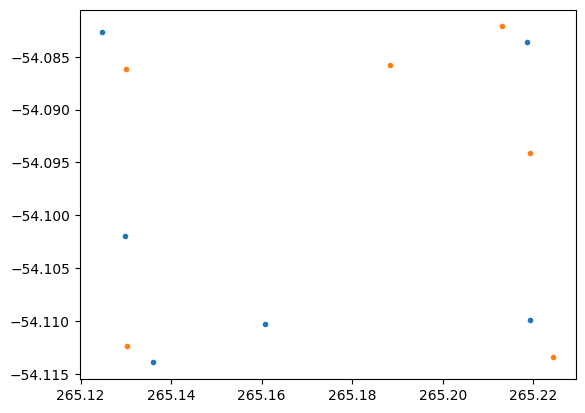

In [116]:
# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)
# counts = Counter(match_res_ra_gaia)
# temp_index = np.array(list(counts.values())) > index_num
# match_res_ra_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

# counts = Counter(match_res_dec_gaia)
# match_res_dec_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

index = 100
plt.plot(match_res_ra_sex_uniqe[0:index], match_res_dec_sex_uniqe[0:index], ".")
plt.plot(match_res_ra_gaia_uniqe[0:index], match_res_dec_gaia_uniqe[0:index], ".")

# print(match_res_ra_sex_uniqe)
# print(match_res_dec_sex_uniqe)
# print(match_res_xindex_sex_uniqe)
# print(match_res_yindex_sex_uniqe)
# print(match_res_ra_gaia_uniqe)
# print(match_res_dec_gaia_uniqe)

### 初步底片模型

In [117]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe / (np.pi / 180)
Y_eta = match_res_eta_gaia_uniqe / (np.pi / 180)
cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))

A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)

print(A_CD)

# 应用
match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
# match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

(match_radec[0] - match_res_ra_gaia_uniqe) * 3600000
(match_radec[1] - match_res_dec_gaia_uniqe) * 3600000

[[-1.90294531e-05  1.38820933e-05 -3.35074535e-09 -2.29032805e-12
   2.20459909e-11  1.44286761e-11]
 [ 2.63783309e-05 -1.76535511e-09 -1.38595796e-05 -1.56148872e-11
  -3.50422755e-12  1.44462653e-12]]


array([-2.55795385e-08, -2.55795385e-08, -2.55795385e-08,  2.55795385e-08,
       -2.55795385e-08, -2.55795385e-08])

### 更新底片模型

In [256]:
# 全体星应用
sext_out_x = sext_out_filter[:]["X_IMAGE"]
sext_out_y = sext_out_filter[:]["Y_IMAGE"]
sext_out_mag = sext_out_filter[:][f"mag_{band}"]

sext_out_xieta = use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD, cof)
sext_out_radec = ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

# 全体再次匹配
refcat_lib_all = pd.DataFrame({"RA_ICRS": np.array(refcat["RA_ICRS"]), "DE_ICRS": np.array(refcat["DE_ICRS"])})
side_threshold = 0.0001
match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all - temp_lib) < side_threshold, axis=1) ==2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), np.array(refcat_lib_all[index].loc[:, :"DE_ICRS"])[0])))

match_res_all = np.array(match_res_all)

# 更新底片模型及
match_res_xi_gaia_all, match_res_eta_gaia_all = cel_ideal_coord(match_res_all[:, 0], match_res_all[:, 1], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all / (np.pi / 180)
Y_eta = match_res_eta_gaia_all / (np.pi / 180)

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_mag_sext_all = np.zeros_like(match_res_xi_gaia_all)
for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]
    match_res_mag_sext_all[index] = sext_out_mag[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag = match_res_mag_sext_all
print(len(match_x))

cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof = 4
A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)

print(A_CD)

# 再应用底片模型
match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

# 残差
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

# # plt.plot(match_x, match_y, '.')

272
[[-1.90296789e-05  1.38820930e-05 -3.35049879e-09 -2.29018664e-12
   2.20460452e-11  1.44291221e-11  7.47140983e-20 -2.47008856e-20
  -1.76346521e-19 -2.12588727e-19 -2.43823330e-23  6.88847433e-24
   6.40784948e-23 -2.09604854e-23 -2.20849941e-22]
 [ 2.63783175e-05 -1.76535463e-09 -1.38595796e-05 -1.56148833e-11
  -3.50423219e-12  1.44465643e-12  3.03962824e-22 -3.15728034e-22
   1.03526975e-21 -1.62205352e-21 -4.71321036e-25  3.33720580e-25
   2.23721599e-24  9.11150838e-25 -1.24637805e-23]]


### 残差图

In [258]:
# create bins
bins_num = 4
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate distortion error model
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

In [259]:
def match_box_id(points_x, points_y, bins_x, bins_y):
    # bins_x_id and bins_y_id
    bins_x_id = np.digitize(points_x, bins_x) - 1
    bins_y_id = np.digitize(points_y, bins_y) - 1

    return bins_x_id, bins_y_id


def cal_distort_model(dis_res_xy_list, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y):

    for points_inf in dis_res_xy_list:
        points_x = points_inf[0, :]
        points_y = points_inf[1, :]
        distort_value_x = points_inf[2, :]
        distort_value_y = points_inf[3, :]

        bins_x_id, bins_y_id = match_box_id(points_x, points_y, bins_x, bins_y)

        distort_bins, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)))
        distort_values_x, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_x)
        distort_values_y, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_y)

        distort_sum_bins += distort_bins
        distort_sum_values_x += distort_values_x
        distort_sum_values_y += distort_values_y

    return distort_sum_bins, distort_sum_values_x, distort_sum_values_y

In [260]:
dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

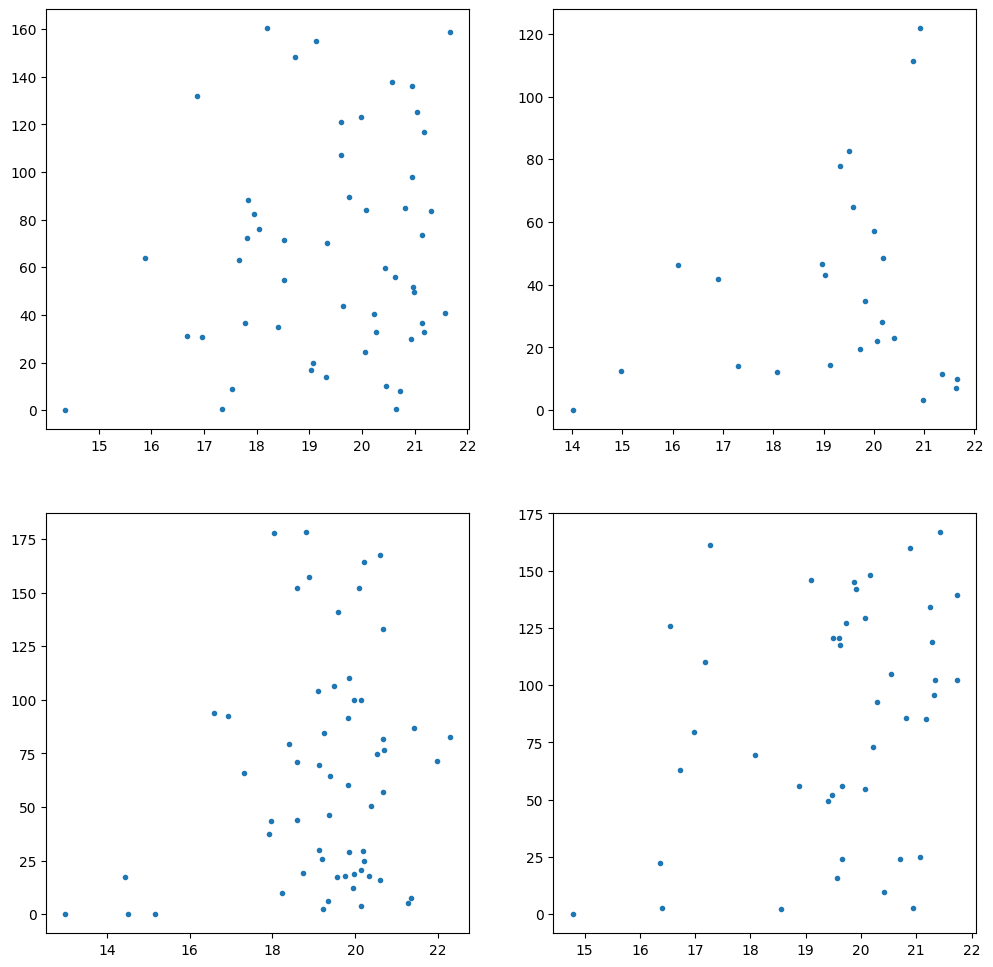

In [264]:
# mag-distortion
bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

fig, axes = plt.subplots(2, 2, figsize= (12, 12))

for i in [1, 2]:
    for j in [1, 2]:
        index = (bins_x_id == i) & (bins_y_id == j)
        axes[i - 1][j - 1].plot(match_mag[index], np.abs(dis_ra[index]), '.')

### test

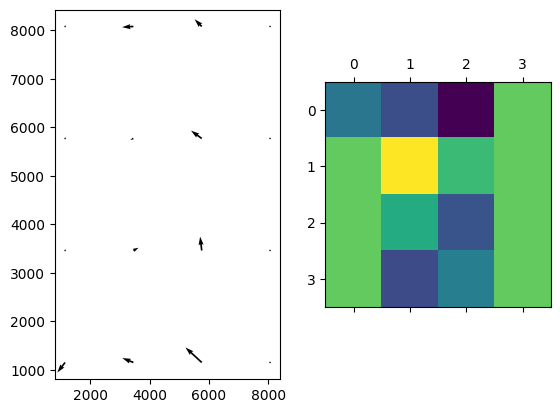

In [265]:
fig, axes = plt.subplots(1, 2)
axes[0].quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten(), distort_mean_values_y.flatten(), scale=1500)

axes[1].matshow(distort_mean_values_x)

# ax = plt.matshow(distort_mean_values_x)
# plt.colorbar(ax.colorbar, fraction=0.025)
# plt.title("matrix X");
# plt.show()